In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
# Load all three datasets:
data_prices = pd.read_csv('houses_price.csv')
data_address = pd.read_csv('houses_address.csv')
data_details = pd.read_csv('houses_details.csv')
data_population = pd.read_csv('houses_population.csv')
data_neighbourhood = pd.read_csv('houses_neighborhood.csv', encoding='latin-1')

In [40]:
######################################################################
###################INSERT FUNCTIONS HERE##############################
######################################################################

# NEIGHBOURHOOD
# extract distances from the points of interest:
import ast
import re
def extractDistances(x):
    if str(x) != 'nan':
        x = ast.literal_eval(x)[1]
        word_list = x.split(' ') 
        distance = word_list[0]
        units = word_list[1]
        distance = float(distance.replace(',', '.'))
        if units == 'kilometer':
            distance = distance*1000
    else: 
        distance = np.nan
    return distance

# DETAILS
# use this function on any column that has m, m^2, m^3 in it
# make for data_details dataframe.
def removeUnitsMeters(x):
    if str(x) not in ['-', 'nan', 'NaN']:
        if isinstance(x, float):
            x = x
        else:
            x = float(x.split(' ')[0])
    else:
        x = np.nan
    return x

# POPULATION
# apply to: data_population.distribution_fm = data_population.distribution_fm.apply(female_to_male_ratio)
def female_to_male_ratio(x):
    if (str(x) not in ['nan', 'NaN', '-']):
        info_both = re.findall("\d+\.\d+", x)
        if len(info_both)>1:
            males = float(info_both[1])
            females = float(info_both[0])
            ratio = females/males
        else:
            ratio = np.nan
    else:
        ratio = np.nan
    return ratio

def get_population_density(x):
    if (str(x) not in ['nan', 'NaN', '-']):
        info_both = re.findall("\d+\.\d+", x)
        if len(info_both)>0:
            density = float(info_both[0])
        else:
            density = np.nan
    else:
        density = np.nan
    return density

# returns percentages
def get_percentage(x):
    if (str(x) not in ['nan', 'NaN', '-']):
        info_both = re.findall("\d+\.\d+", x)
        if len(info_both)==0:
            info_both = re.findall("\d+", x)
            if len(info_both)>0:
                percentage = float(info_both[0])
                if len(info_both)>1:
                    percentage = percentage + float(info_both[1])/100
            else:
                percentage = np.nan
        elif len(info_both)>1:
            percentage = float(info_both[0]) + float(info_both[1])/100
    else:
        percentage = np.nan
    return percentage/100

def remove_currency(x):
    if (str(x) not in ['nan', 'NaN', '-']):
        info_both = re.findall("\d+\.\d+", x)
        if len(info_both)>0:
            euros = float(info_both[0])
        else:
            euros = np.nan
        return euros

# PRICES:

def fix_price(x):
    price_list = re.findall("\d+", x)
    if len(price_list)>0:
        if len(price_list)>2:
            price = float(price_list[0])*1e6 + float(price_list[1])*1e3 + float(price_list[2])
        elif len(price_list) == 2:
            price = float(price_list[0])*1e3 + float(price_list[1])
        elif len(price_list) == 1:
            price = float(price_list[0])*1e3
    else:
        price = 0
    return price

# remove letters from zip codes:
def remove_letters_zipcode(x):
    zipcode = re.findall("\d+", x)
    if len(zipcode)==1:
        to_return = int(zipcode[0])
    else:
        to_return = np.nan
    return to_return

In [41]:
# Use extractDistances(x) to get relevant information from the neighbourhood dataframe:
data_neighbourhood = data_neighbourhood.applymap(extractDistances)

# Use removeUnitsMeters to remove m2 and m3 from specific columns
data_details.Living_area = data_details.Living_area.apply(removeUnitsMeters)
data_details.LOT = data_details.LOT.apply(removeUnitsMeters)
data_details.Plot = data_details.Plot.apply(removeUnitsMeters)

# Fix female to male ratio:
data_population.distribution_fm = data_population.distribution_fm.apply(female_to_male_ratio)

# Fix population density:
data_population.population_density = data_population.population_density.apply(get_population_density)

# Fix population columns:
perc_cols = ['Age_0-15', 'age_15-25', 'age_25-45', 'age_45-65', 'age_older', 'indigenous', 'western_allochtoon', 'none_western', 'household_single', 'household_wo_kids', 'household_with_kids', 'perc_with_job', 'high_income', 'medium_income', 'low_income', 'social_benefit'] 
data_population.loc[:, perc_cols] = data_population.loc[:, perc_cols].applymap(get_percentage)
data_population.loc[:, 'income_avg'] = data_population.loc[:, 'income_avg'].apply(remove_currency)

# Fix property prices:
cols_to_fix = ['current_price', 'original_price', 'changes_in_price']
data_prices.loc[:, cols_to_fix] = data_prices.loc[:, cols_to_fix].applymap(fix_price)

# Fix zipcodes:
data_address.Zipcode = data_address.Zipcode.apply(remove_letters_zipcode)

In [42]:
# Concatenate all data to get a complete data frame:
data_frame = pd.concat([data_address, data_prices, data_details, data_neighbourhood, data_population], axis=1)

At this point, we got out dataset. But we do not neeed all of the variables that are listed in there. For this reason, I will remove some that we do not need in our model.

In [43]:
data_frame.drop(columns = ['Street','Graden', 'Price', 'price', 'original_price', 'Balcony', 'Garage', 'view', 'inside_maintenance_state', 'outside_maintenace_state', 'outside_state_painting', 'kitchen', 'Sanitation', 'Energy_consumption', 'Other','Insulation','Heating', 'Energy_label', 'Broker', 'posted_date', 'number_of_times_shown', 'number_of_times_shown_yesterday', 'videotheek', 'changes_in_price'], inplace = True)

In [44]:
data_frame.head(20)

,Zipcode,current_price,price_per_m2,times_in_sales,Type,Construction_year,Living_area,LOT,Plot,Rooms,...,household_single,household_wo_kids,household_with_kids,avg_person_per_household,perc_with_job,high_income,medium_income,low_income,income_avg,social_benefit
0,1034.0,585000,3.656,Nieuw,Herenhuis,1995,160.0,556.000,220.00,5,...,0.43,0.21,0.37,"2,2",0.63,0.11,0.46,0.43,16.4,0.1007
1,1067.0,325000,3.250,Nieuw,Hoekwoning,1955,100.0,328.000,80.00,5,...,0.43,0.20,0.37,"2,2",0.62,0.09,0.45,0.46,15.5,0.1107
2,1086.0,910000,3.889,5 dagen,Herenhuis,2008,234.0,874.000,144.00,8,...,0.30,0.18,0.53,"2,6",0.81,0.37,0.40,0.23,23.4,0.0500
3,1016.0,1.05e+06,7.554,Nieuw,Dubbele bovenwoning,1620,139.0,NaN,66.00,5,...,0.65,0.23,0.12,"1,5",0.69,0.44,0.26,0.30,30.2,0.0100
4,1035.0,1.395e+06,4.619,23 dagen,Vrijstaande woning,1751,302.0,1.259,1.47,7,...,0.36,0.24,0.40,"2,2",0.73,0.20,0.44,0.36,17.9,0.0505
5,1026.0,700000,6.796,3 maanden,Eengezinswoning,1968,103.0,319.000,265.00,5,...,0.29,0.32,0.39,"2,4",0.76,0.36,0.34,0.30,24.3,0.0005
6,1054.0,1.65e+06,5.789,1 maand,Tussenwoning,1904,285.0,1.043,90.00,10,...,0.64,0.19,0.18,"1,6",0.76,0.31,0.37,0.32,22.3,0.0405
7,1019.0,1.589e+06,4.966,3 dagen,Woonboot,1936,320.0,735.000,1.00,11,...,0.43,0.25,0.33,"2,0",0.80,0.40,0.37,0.23,24.8,0.0408
8,1079.0,1.95e+06,8.744,5 dagen,Woning,1968,223.0,903.000,228.00,9,...,0.57,0.22,0.21,"1,7",0.77,0.32,0.39,0.29,22.6,0.0300
9,1015.0,850000,6.071,10 dagen,Herenhuis,1005,140.0,500.000,48.00,4,...,0.69,0.18,0.13,"1,4",0.72,0.26,0.37,0.37,21.0,0.0601


In [45]:
data_frame.to_csv('CompleteData.csv', sep = ',', index = False)

In [50]:
data_frame.current_price.values

array([585000.0, 325000.0, 910000.0, ..., 349000.0, 315000.0, 275000.0], dtype=object)

In [55]:
data_frame.current_price = pd.to_numeric(data_frame.current_price)

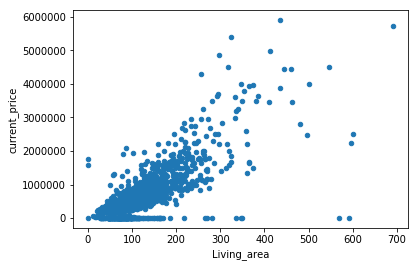

In [57]:
data_frame.plot(x = 'Living_area', y = 'current_price', kind = 'scatter')